In [14]:
import duckdb
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

con = duckdb.connect()

In [15]:
def read_csv(path):
    con.execute(f"""
    select column0 as sys, column1 as q, column2 as size
    from read_csv_auto('{path}')
    """)
    return con.fetchdf()

In [16]:
def normalize(df, baseline):
    con.register('my_df', df)
    con.execute(f"""
    select r.sys, r.q, r.size as size, bl.size as baseline,
           round(r.size::DOUBLE / bl.size::DOUBLE, 2) as relative_cost
    from my_df r,
         my_df bl
    where bl.sys = '{baseline}'
      and r.q = bl.q
    order by case when r.sys = 'duckdb' then 1 when r.sys = 'postgres' then 2 else 3 end
    """)
    return con.fetchdf()

In [17]:
def plot(df, max_y):
    aspect = len(df['q'].unique()) / 2 * len(df['sys'].unique()) / 3
    fig = sns.catplot(data=df, kind='bar', x='q', y='relative_cost', hue='sys', height=5, aspect=aspect)
    ax = fig.axes[0][0]

    for rect in ax.patches:
        h = rect.get_height()
        if np.isnan(h):
            continue
        c = rect._original_facecolor
        draw_y = h + 1 if h < max_y else max_y / 2
        ax.text(rect.get_x() + rect.get_width()/2., draw_y, str(h), ha='center', va='bottom',
                fontsize=10, bbox=dict(facecolor='white', edgecolor=c),
                fontweight='bold', color=c)
    fig._legend.set_visible(False)
    ax.set(ylim=(0, max_y))
    ax.legend(frameon=True, framealpha=1, loc='upper left')
    plt.show()

In [22]:
def compute_stats(df):
    con.register('my_df', df)
    con.execute("""
    select sys,
           min(relative_cost) as min,
           max(relative_cost) as max,
           avg(relative_cost) as avg,
           median(relative_cost) as median
    from my_df
    group by sys
    """)
    return con.fetchdf()

In [53]:
def boxplot(df, yscale=None):
    ax = sns.boxplot(data=df, x='sys', y='relative_cost')
    ax.set(yscale=yscale)
    plt.show()

## JOB

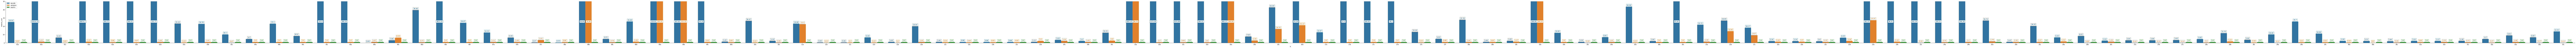

In [60]:
df_raw = read_csv('plan-cost-new.tsv')

con.execute("""
select * from df_raw
where sys = 'duckdb'
   or sys = 'explicit'
   or sys = 'postgres'
""")
df_raw = con.fetchdf()

df = normalize(df_raw, 'explicit')
plot(df, 50)

In [61]:
compute_stats(df)

,sys,min,max,avg,median
0,duckdb,0.04,18874.70,421.261389,11.365
1,postgres,0.00,346.04,11.608611,1.000
2,explicit,1.00,1.00,1.000000,1.000


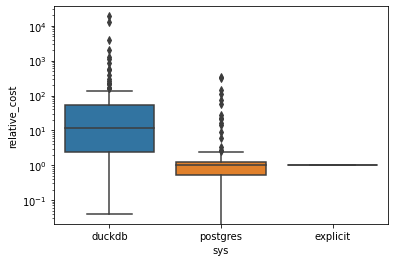

In [62]:
boxplot(df, yscale='log')

## TPC-H

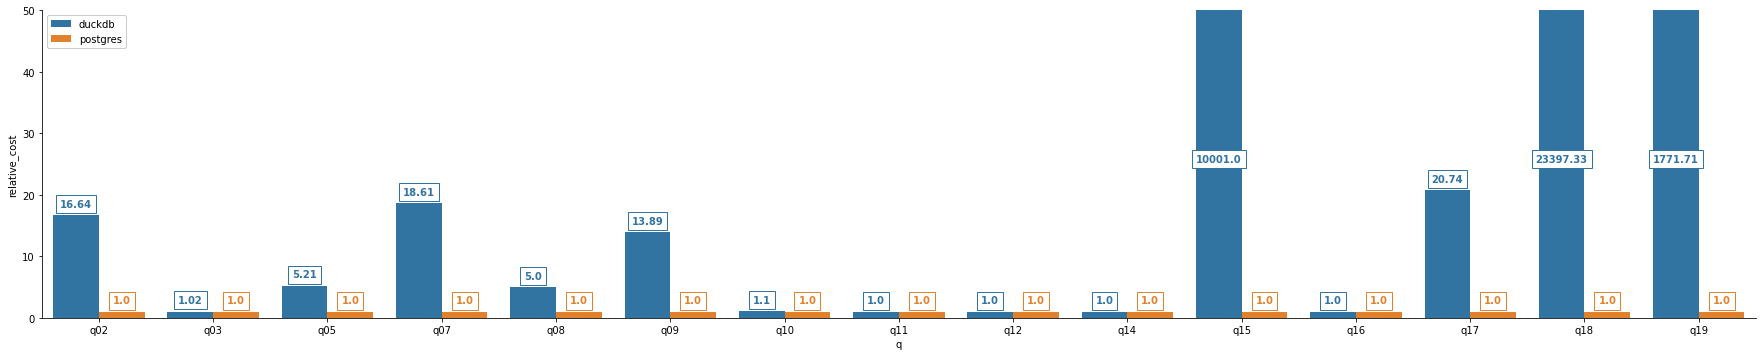

In [50]:
df_raw = read_csv('/Users/laurens/git/tpch-join-order/plan-cost.tsv')

con.execute("""
select * from df_raw
where sys = 'duckdb'
   or sys = 'postgres'
""")
df_raw = con.fetchdf()

df = normalize(df_raw, 'postgres')
plot(df, 50)

In [51]:
compute_stats(df)

,sys,min,max,avg,median
0,duckdb,1.0,23397.33,2350.416667,5.21
1,postgres,1.0,1.00,1.000000,1.00


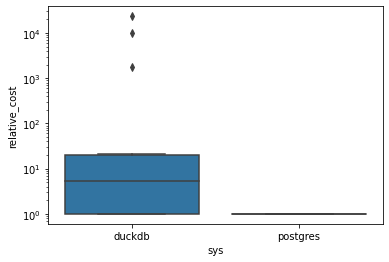

In [56]:
boxplot(df, yscale='log')